# Analyzing Real User Data in Government

Using the "weekly snapshot" data export from site scanning the week of July 22, 2024, we create a list of unique origins from the site scanning report. This is then fed into BigQuery where we create a report of origins from the site scanning report who were both eligible for and contained enough data to show up in the Chrome User Experience (CrUX) report.

In [393]:
import os
import pandas as pd

notebook_dir = os.getcwd()


file_name = 'data/site-scanning-weekly-snapshot-20240722.csv'
file_path = os.path.join(notebook_dir, file_name)

df = pd.read_csv(file_path)
final_url_website_data = df['final_url_website'].unique()
final_url_website_list = final_url_website_data.astype(str).tolist()
final_url_website_str = ', '.join("'https://" + str(url) + "'" for url in final_url_website_list)

## Use this in the sql query 'where in' clause
#print(final_url_website_str)


## Methodology

We are examining trends in government sites for Core Web Vitals metrics among real users over a 6-month period and comparing them to non-government sites. In this case, the threshold for "good" is targeting p75 using the parameters defined by Google in their core web vitals metrics.


In [394]:
import matplotlib.pyplot as plt

def plot_cwv_results(df, percentile):
    df.set_index('date', inplace=True)

    plt.figure(figsize=(20, 6))
    pos = list(range(len(df.index)))
    width = 0.2
    edgecolor='#808080'
    
    #942ddb, #725ffc, #2588fe, #009ff4, #00bbdf, #00d2ad, #2ddb69
    bars1 = plt.bar(pos, df['pct_good_cls']*100, width, alpha=1, color='#942ddb', edgecolor=edgecolor)
    bars2 = plt.bar([p + width for p in pos], df['pct_good_lcp']*100, width, alpha=1, color='#009ff4', edgecolor=edgecolor)
    bars3 = plt.bar([p + 2 * width for p in pos], df['pct_good_inp']*100, width, alpha=1, color='#2ddb69', edgecolor=edgecolor)
    
    
    plt.title('Core Web Vitals By Month')
    plt.xlabel('Month')
    plt.ylabel(f'% achieving a "good" rating at {percentile}')
    plt.ylim([0, 100])
    
    plt.xticks([p + 1.5 * width for p in pos], df.index)
    
    plt.legend([bars1, bars2, bars3],
               ['CLS', 'LCP', 'INP', ], loc='lower left')
    plt.grid()
    plt.show()
    

## US Government Sites

Here are the CWV metrics from origins that are found in the site scanning report. From the data below, the metric that is least likely to achieve a qualitative score of "good" is Largest Contentful Paint (LCP). 

In [395]:
file_name = 'data/cwv-in-government-p75.csv'
file_path = os.path.join(notebook_dir, file_name)

dfInGov = pd.read_csv(file_path)
dfInGov = dfInGov[dfInGov['client'] == 'mobile'].sort_values(by='date', ascending=True)
dfInGov.head(50)

,date,client,origins,origins_with_good_inp,origins_with_good_cls,origins_with_good_ttfb,origins_with_good_fcp,origins_with_good_lcp,origins_with_any_inp,origins_with_any_cls,...,origins_with_any_fcp,origins_with_any_lcp,origins_with_good_cwv,origins_eligible_for_cwv,pct_good_ttfb,pct_good_fcp,pct_good_lcp,pct_good_cls,pct_good_inp,pct_eligible_origins_with_good_cwv
1,2024-01-01,mobile,4394,2500,3147,1218,1579,2096,3365,3739,...,3744,3695,1534,3694,0.328834,0.421741,0.567253,0.841669,0.742942,0.392502
8,2024-02-01,mobile,4375,2491,3153,1185,1531,2086,3359,3755,...,3763,3707,1531,3705,0.318206,0.406856,0.562719,0.839680,0.741590,0.391304
7,2024-03-01,mobile,4462,2546,3197,1206,1644,2223,3369,3787,...,3791,3736,1680,3735,0.321257,0.433659,0.595021,0.844204,0.755714,0.427498
4,2024-04-01,mobile,4516,2585,3236,1181,1606,2193,3390,3804,...,3810,3756,1656,3756,0.313180,0.421522,0.583866,0.850683,0.762537,0.418863
5,2024-05-01,mobile,4559,2579,3247,1032,1466,2039,3385,3827,...,3834,3767,1520,3766,0.272152,0.382368,0.541280,0.848445,0.761891,0.383768
11,2024-06-01,mobile,4564,2619,3202,1151,1686,2245,3368,3772,...,3778,3738,1713,3738,0.307343,0.446268,0.600589,0.848887,0.777613,0.435156


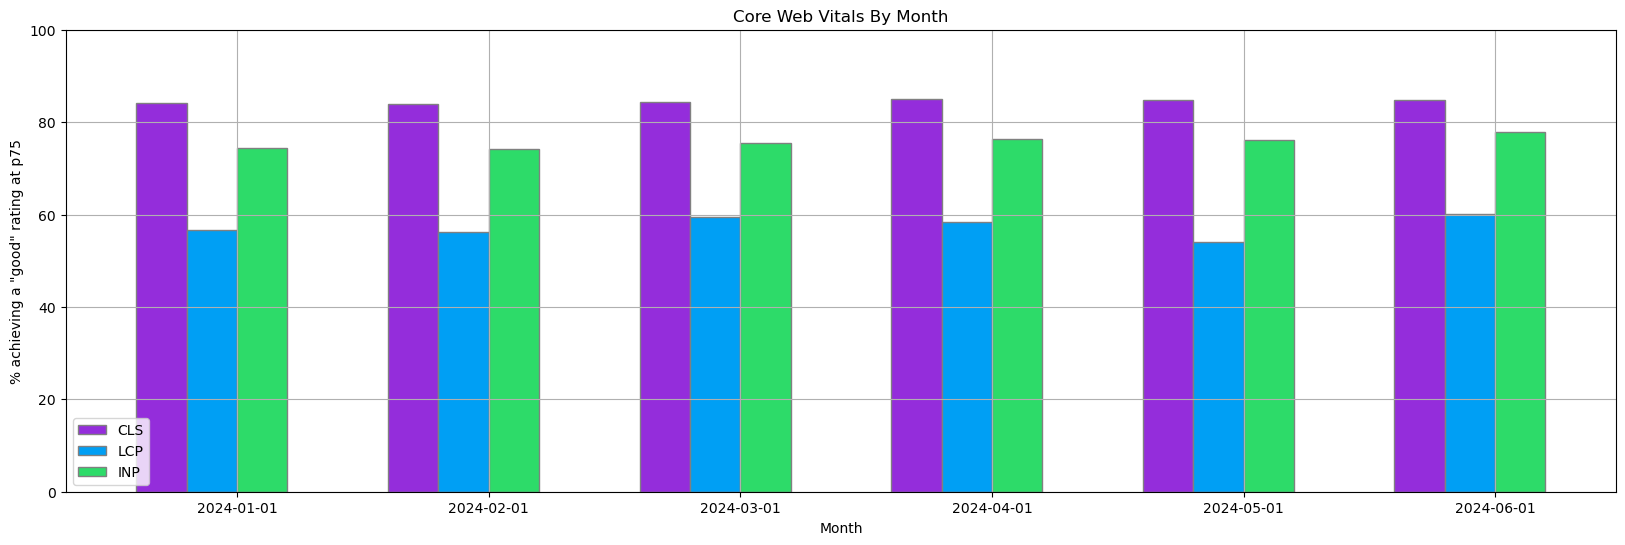

In [396]:
plot_cwv_results(dfInGov, 'p75')

## All other sites

Here is the data for all other sites with the origins from the site scanning report excluded from the data set to capture how US government sites compare with the industry as a whole.

In [397]:
file_name = 'data/cwv-not-in-government-p75.csv'
file_path = os.path.join(notebook_dir, file_name)

dfNotInGov = pd.read_csv(file_path)
dfNotInGov = dfNotInGov[dfNotInGov['client'] == 'mobile'].sort_values(by='date', ascending=True)
dfNotInGov.head(50)

,date,client,origins,origins_with_good_inp,origins_with_good_cls,origins_with_good_ttfb,origins_with_good_fcp,origins_with_good_lcp,origins_with_any_inp,origins_with_any_cls,...,origins_with_any_fcp,origins_with_any_lcp,origins_with_good_cwv,origins_eligible_for_cwv,pct_good_ttfb,pct_good_fcp,pct_good_lcp,pct_good_cls,pct_good_inp,pct_eligible_origins_with_good_cwv
10,2024-01-01,mobile,17608211,5774939,8860195,4518624,5641224,6324949,8478610,11325194,...,11410444,11041708,4438693,11008175,0.416042,0.494391,0.572823,0.782344,0.681119,0.390258
0,2024-02-01,mobile,17772904,5705751,8770371,4448756,5533908,6225014,8428004,11214265,...,11301089,10927616,4363366,10893768,0.412689,0.489679,0.569659,0.782073,0.676999,0.387866
11,2024-03-01,mobile,17684179,5875508,8784696,4484632,5604823,6304298,8390686,11145597,...,11231373,10859885,4509516,10826134,0.419425,0.499033,0.580512,0.788176,0.700242,0.403989
7,2024-04-01,mobile,17718149,5976746,8837992,4474500,5637154,6331438,8383618,11157601,...,11243598,10868031,4589794,10833419,0.418358,0.501366,0.582575,0.792105,0.712908,0.411327
4,2024-05-01,mobile,17729471,6069417,8859176,4473477,5591686,6304496,8409052,11202836,...,11290942,10908351,4590487,10873137,0.417081,0.495236,0.577951,0.790798,0.721772,0.410513
8,2024-06-01,mobile,17550222,6166626,8830458,4460493,5734015,6416714,8346080,11131533,...,11219631,10838260,4718796,10802930,0.419027,0.511070,0.592043,0.793283,0.738865,0.425086


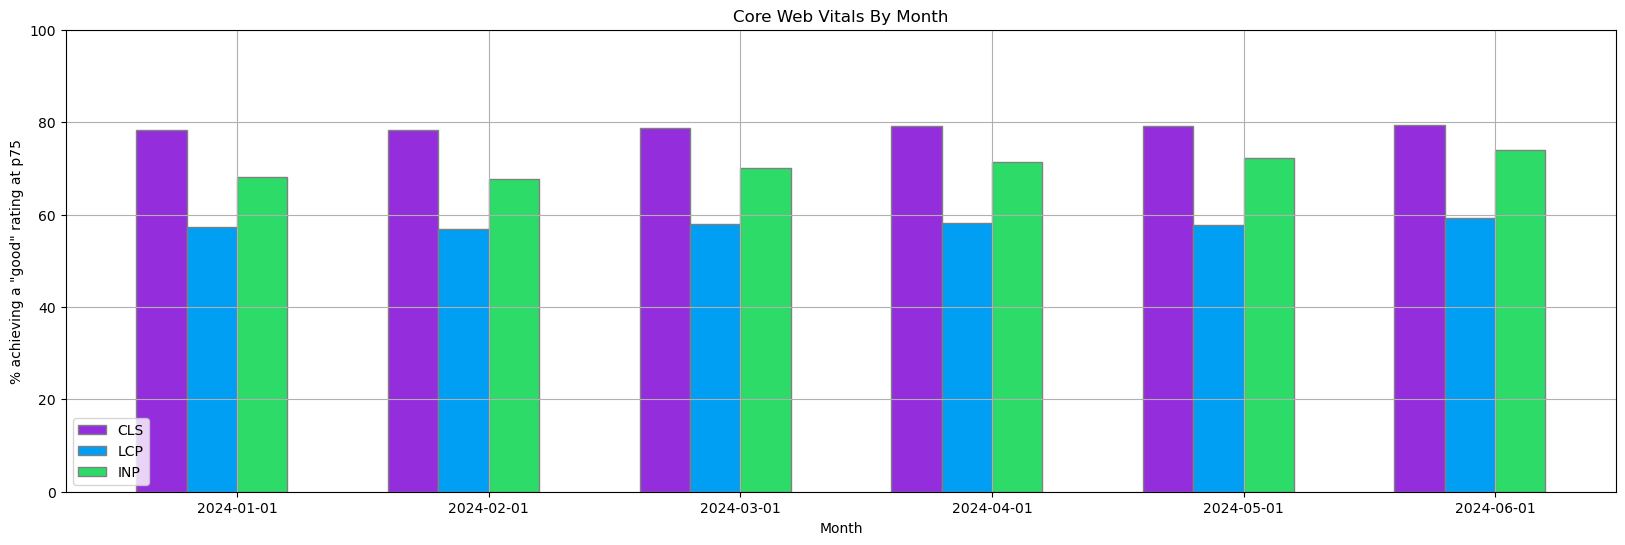

In [398]:
plot_cwv_results(dfNotInGov, 'p75')

## Comparison of individual metrics

Here is a direct comparison of individual metrics between origins in the site scanning report vs. those origins not in the site scanning report.

In [399]:
dfInGov.index = pd.to_datetime(dfInGov.index)
dfNotInGov.index = pd.to_datetime(dfNotInGov.index)

# Merge dataframes on index
merged_df = pd.merge(dfInGov, dfNotInGov, left_index=True, right_index=True, suffixes=('_dfInGov', '_dfNotInGov'))



In [400]:
def plot_individual_metric_comparison(df, column1, column2, metric, percentile):
    width = 0.2
    edgecolor='#808080'
    
    # Make the plot
    plt.figure(figsize=(10, 5))

    pos = list(range(len(df.index)))
    bars1 = plt.bar(pos, column1*100, width, alpha=1, color='#942ddb', edgecolor=edgecolor)
    bars2 = plt.bar([p + width for p in pos], column2*100, width, alpha=1, color='#2ddb69', edgecolor=edgecolor)
    
    
    # Adding title and labels to the axes
    plt.xlabel('Date', fontweight='bold', fontsize=15)
    plt.ylabel(f'% "good" at {percentile}', fontweight='bold', fontsize=15)
    plt.title(f'Comparison of good {metric} values', fontweight='bold', fontsize=20)
    plt.xticks([r + width for r in range(len(bars1))], df.index.date)
    
    # Create legend
    plt.legend([bars1, bars2], ['Government', 'Not Government'], loc='lower left')
    
    plt.grid()
    plt.show()


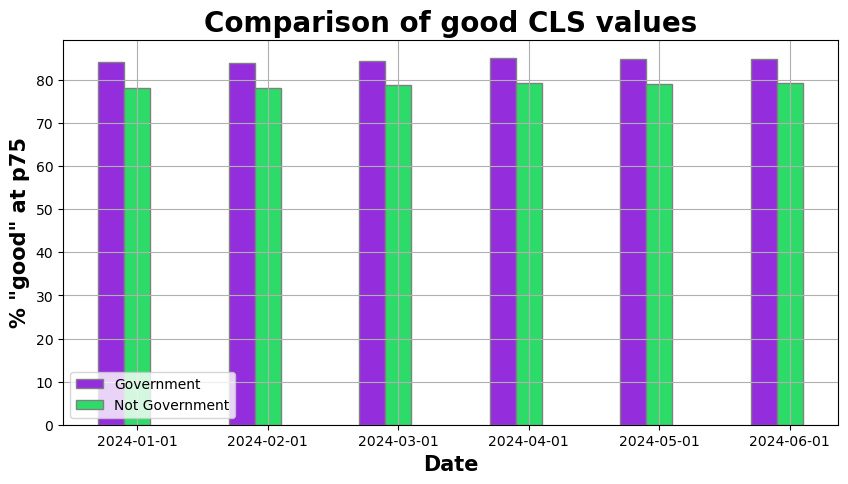

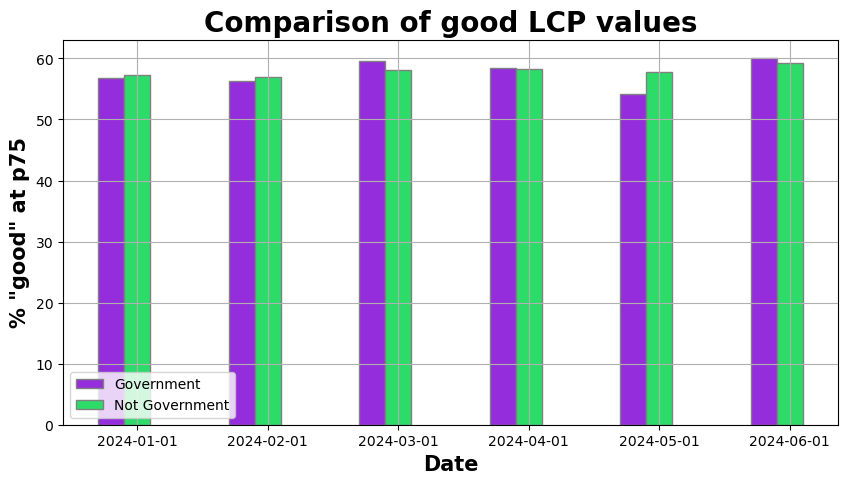

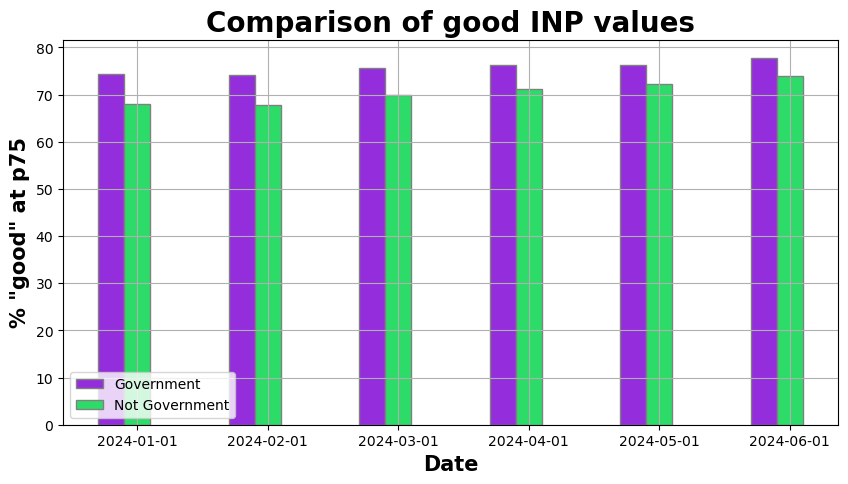

In [401]:
plot_individual_metric_comparison(merged_df, merged_df['pct_good_cls_dfInGov'], merged_df['pct_good_cls_dfNotInGov'], 'CLS', 'p75')
plot_individual_metric_comparison(merged_df, merged_df['pct_good_lcp_dfInGov'], merged_df['pct_good_lcp_dfNotInGov'], 'LCP', 'p75')
plot_individual_metric_comparison(merged_df, merged_df['pct_good_inp_dfInGov'], merged_df['pct_good_inp_dfNotInGov'], 'INP', 'p75')

In [402]:
file_name = 'data/cwv-not-in-government-p90.csv'
file_path = os.path.join(notebook_dir, file_name)

dfNotInGov = pd.read_csv(file_path)
dfNotInGov = dfNotInGov.reset_index()
dfNotInGov.set_index('date', inplace=True)

dfNotInGov = dfNotInGov[dfNotInGov['client'] == 'mobile'].sort_values(by='date', ascending=True)

In [403]:
file_name = 'data/cwv-in-government-p90.csv'
file_path = os.path.join(notebook_dir, file_name)

dfInGov = pd.read_csv(file_path)
dfInGov = dfInGov.reset_index()
dfInGov.set_index('date', inplace=True)
dfInGov = dfInGov[dfInGov['client'] == 'mobile'].sort_values(by='date', ascending=True)

dfInGov.head(50)

,index,client,origins,origins_with_good_inp,origins_with_good_cls,origins_with_good_ttfb,origins_with_good_fcp,origins_with_good_lcp,origins_with_any_inp,origins_with_any_cls,...,origins_with_any_fcp,origins_with_any_lcp,origins_with_good_cwv,origins_eligible_for_cwv,pct_good_ttfb,pct_good_fcp,pct_good_lcp,pct_good_cls,pct_good_inp,pct_eligible_origins_with_good_cwv
date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,9,mobile,4394,1154,2420,212,316,664,3365,3739,...,3744,3695,271,3694,0.057235,0.084402,0.179702,0.647232,0.342942,0.065263
2024-02-01,7,mobile,4375,1134,2398,207,303,651,3359,3755,...,3763,3707,249,3705,0.055585,0.080521,0.175614,0.638615,0.337600,0.061836
2024-03-01,3,mobile,4462,1268,2494,179,316,686,3369,3787,...,3791,3736,299,3735,0.047682,0.083355,0.183619,0.658569,0.376373,0.074200
2024-04-01,1,mobile,4516,1349,2534,189,322,678,3390,3804,...,3810,3756,316,3756,0.050119,0.084514,0.180511,0.666141,0.397935,0.076904
2024-05-01,5,mobile,4559,1323,2481,169,280,568,3385,3827,...,3834,3767,234,3766,0.044568,0.073031,0.150783,0.648288,0.390842,0.058176
2024-06-01,11,mobile,4564,1409,2488,176,338,692,3368,3772,...,3778,3738,314,3738,0.046996,0.089465,0.185126,0.659597,0.418349,0.077144


In [404]:
dfInGov.index = pd.to_datetime(dfInGov.index)
dfNotInGov.index = pd.to_datetime(dfNotInGov.index)

# Merge dataframes on index
merged_df = pd.merge(dfInGov, dfNotInGov, left_index=True, right_index=True, suffixes=('_dfInGov', '_dfNotInGov'))

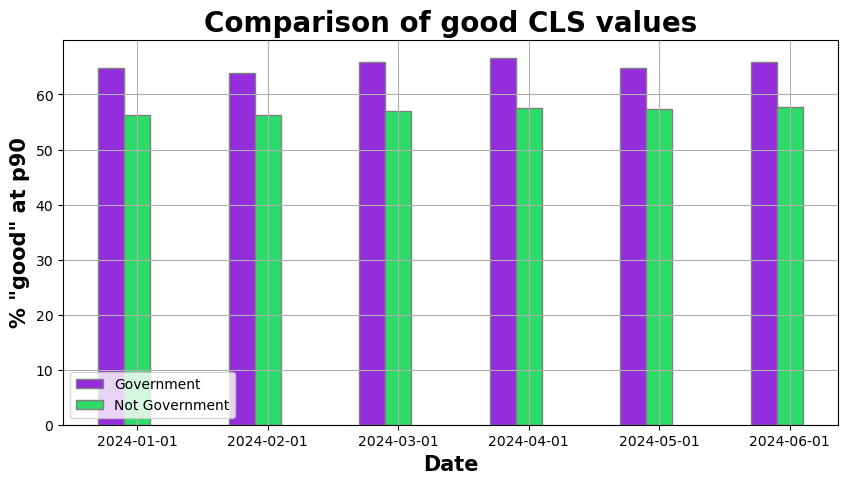

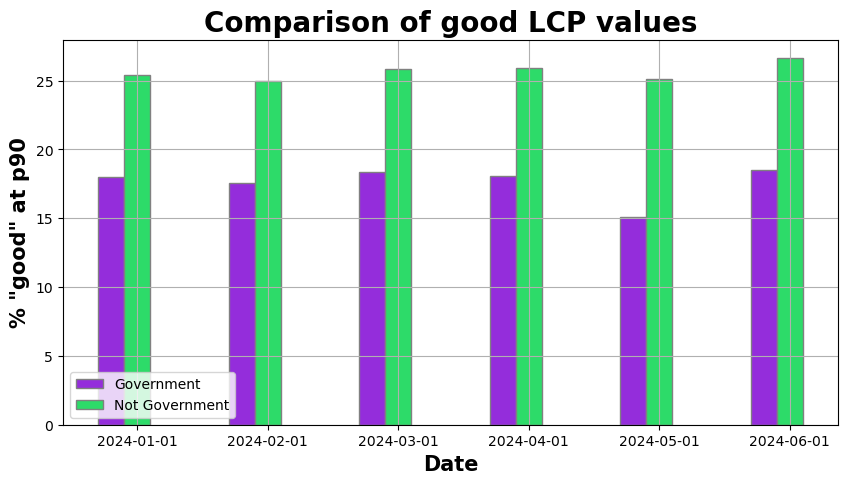

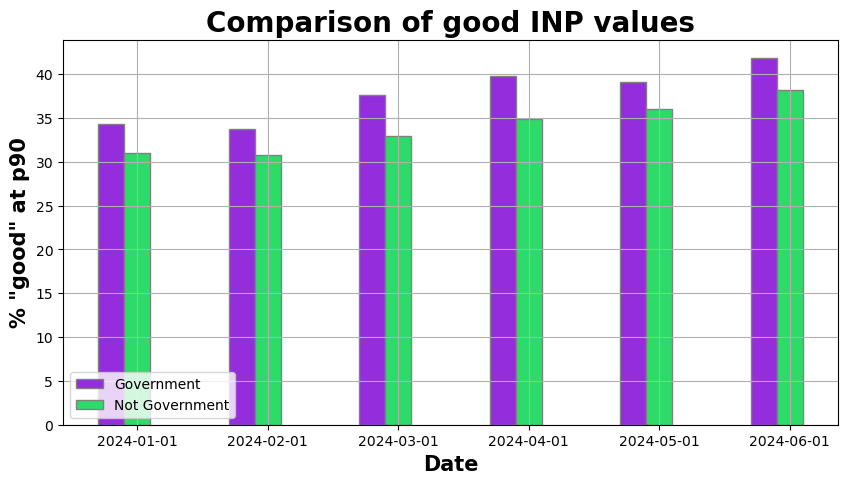

In [405]:
plot_individual_metric_comparison(merged_df, merged_df['pct_good_cls_dfInGov'], merged_df['pct_good_cls_dfNotInGov'], 'CLS', 'p90')
plot_individual_metric_comparison(merged_df, merged_df['pct_good_lcp_dfInGov'], merged_df['pct_good_lcp_dfNotInGov'], 'LCP', 'p90')
plot_individual_metric_comparison(merged_df, merged_df['pct_good_inp_dfInGov'], merged_df['pct_good_inp_dfNotInGov'], 'INP', 'p90')